## Declaring libraries and downloading dataset


In [47]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F
from torch.distributions import Gumbel

from torchsummary import summary

%matplotlib inline

In [48]:
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_dataset = CIFAR100(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [49]:
print(len(dataset))
print(len(test_dataset))

classes = dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

#shape of the image tensor
img, label = dataset[31]
img_shape = img.shape
img_shape

50000
10000
Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tul

torch.Size([3, 32, 32])

In [50]:
print("1 - Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print("2 - Pixel Values for all Channels:\n", img[:, 20:25, 20:25])

1 - Max & Min Pixel Values: Max: tensor(1.) Min: tensor(0.1020)
2 - Pixel Values for all Channels:
 tensor([[[0.5569, 0.6039, 0.6510, 0.6039, 0.8235],
         [0.3961, 0.5922, 0.7529, 0.6824, 0.8314],
         [0.2941, 0.5294, 0.6275, 0.6078, 0.6784],
         [0.3255, 0.4471, 0.4353, 0.4235, 0.4275],
         [0.4667, 0.4667, 0.5020, 0.5725, 0.4706]],

        [[0.4353, 0.4745, 0.5020, 0.4549, 0.6510],
         [0.3020, 0.4706, 0.5882, 0.5098, 0.6706],
         [0.2471, 0.4196, 0.4745, 0.4431, 0.5333],
         [0.2667, 0.3529, 0.3098, 0.2941, 0.3098],
         [0.3922, 0.4039, 0.4196, 0.4902, 0.3922]],

        [[0.4392, 0.4824, 0.5137, 0.4627, 0.6667],
         [0.3020, 0.4745, 0.6000, 0.5216, 0.6745],
         [0.2431, 0.4353, 0.4980, 0.4627, 0.5373],
         [0.2627, 0.3569, 0.3176, 0.2980, 0.3059],
         [0.3490, 0.3490, 0.3647, 0.4314, 0.3333]]])


## Preparing Dataset

In [51]:
torch.manual_seed(2718) ##settling a manual seed to get similar results everytime

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [52]:
batch_size = 128

In [53]:
# Defininf Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)

In [54]:
torch.cuda.is_available()

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

idk


In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Using ResNet 9 structure to train the model

In [56]:
def drop_lowest_values(tensor):
    num_elements = tensor.numel()  # Total number of elements in the tensor
    num_values_to_drop = int(num_elements * 0.1)  # Number of values to drop (10% of total)
    
    if num_values_to_drop == 0:
        return tensor
    
    flattened_tensor = tensor.flatten()  # Flatten the tensor into a 1D tensor
    sorted_indices = torch.argsort(flattened_tensor)  # Sort the indices based on the tensor values
    
    # Set the lowest values to 0
    sorted_indices_to_drop = sorted_indices[:num_values_to_drop]
    flattened_tensor[sorted_indices_to_drop] = 0
    
    # Reshape the tensor back to its original shape
    dropped_tensor = flattened_tensor.reshape(tensor.shape)
    
    return dropped_tensor

In [57]:
class GumbleSoftmax(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, input):
        gumbel_noise = torch.rand_like(input)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-20) + 1e-20)
        logits = (input + gumbel_noise) / self.temperature
        return F.softmax(logits, dim=1)

In [58]:
class LogGumbleSoftmax(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, input):
        gumbel_noise = torch.rand_like(input)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-20) + 1e-20)
        logits = (input + gumbel_noise) / self.temperature
        return F.log_softmax(logits, dim=1)

In [59]:
class PseudoSoftmax(nn.Module):
    def forward(self, input):
        exp_input = torch.pow(2, input)
        softmax_output = exp_input / torch.sum(exp_input, dim=1, keepdim=True)
        return softmax_output

In [70]:
class Z_sm(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,input):
        
        device = input.device
        m = torch.distributions.normal.Normal(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device))
        log_probs = m.cdf(input)
        probabilities = torch.exp(log_probs) / torch.sum(torch.exp(log_probs))
        return probabilities


In [90]:
class ExpSinSoftmax(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        exp_sin_values = torch.exp(torch.tanh(input))
        probabilities = exp_sin_values / torch.sum(exp_sin_values)
        return probabilities


In [100]:
"""Sparsemax activation function.

Pytorch implementation of Sparsemax function from:
-- "From Softmax to Sparsemax: A Sparse Model of Attention and Multi-Label Classification"
-- André F. T. Martins, Ramón Fernandez Astudillo (http://arxiv.org/abs/1602.02068)
"""

from __future__ import division

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.

        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size

        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor

        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [136]:
## Resnet12 Layer Structure

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet12(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.conv5 = conv_block(512, 1024, pool=True)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, num_classes),
                                        GumbleSoftmax(temperature = -1.5),
                                        # PseudoSoftmax(),
                                        # Sparsemax(),
                                        )
        
        # lol this syncs/

        # self.softmax_layer = nn.LogSoftmax(dim = 1)
        # self.softmax_layer = nn.Softmax(dim = 1)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)

        
        # out = drop_lowest_values(out)

        # out = self.softmax_layer(out)

        return out

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
 # for evaluation thingie

In [138]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
     # After completing training, evaluate on the validation set
    model.eval()
    predicted_labels = []
    true_labels = []
    for batch in val_loader:
        outputs = model(batch[0])
        predicted_labels.extend(torch.argmax(outputs, dim=1).tolist())
        true_labels.extend(batch[1].tolist())

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)

    history[-1]['precision'] = precision
    history[-1]['recall'] = recall
    history[-1]['f1'] = f1
    history[-1]['confusion_matrix'] = cm

    return history

In [139]:
model_resnet12 = to_device(ResNet12(3, 100), device)
model_resnet12

ResNet12(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [140]:
summary(model_resnet12, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [141]:
history_resnet12 = [evaluate(model_resnet12, val_loader)]
history_resnet12

[{'val_loss': 4.605234146118164, 'val_acc': 0.009098101407289505}]

**Setting parameters for training**

In [142]:
epochs_resnet12 = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [143]:
%%time
history_resnet12 += fit_one_cycle(epochs_resnet12, max_lr, model_resnet12, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00050, train_loss: 4.5869, val_loss: 4.5783, val_acc: 0.0421
Epoch [1], last_lr: 0.00081, train_loss: 4.5794, val_loss: 4.5810, val_acc: 0.0400
Epoch [2], last_lr: 0.00132, train_loss: 4.5757, val_loss: 4.5767, val_acc: 0.0449
Epoch [3], last_lr: 0.00199, train_loss: 4.5851, val_loss: 4.5901, val_acc: 0.0312
Epoch [4], last_lr: 0.00280, train_loss: 4.5927, val_loss: 4.6063, val_acc: 0.0156
Epoch [5], last_lr: 0.00371, train_loss: 4.5972, val_loss: 4.5966, val_acc: 0.0245
Epoch [6], last_lr: 0.00470, train_loss: 4.5978, val_loss: 4.5898, val_acc: 0.0310
Epoch [7], last_lr: 0.00570, train_loss: 4.5879, val_loss: 4.5955, val_acc: 0.0246
Epoch [8], last_lr: 0.00668, train_loss: 4.5942, val_loss: 4.5883, val_acc: 0.0325
Epoch [9], last_lr: 0.00760, train_loss: 4.5902, val_loss: 4.5898, val_acc: 0.0300
Epoch [10], last_lr: 0.00841, train_loss: 4.5897, val_loss: 4.5928, val_acc: 0.0283
Epoch [11], last_lr: 0.00908, train_loss: 4.5910, val_loss: 4.5980, val_acc: 0.0206
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluating

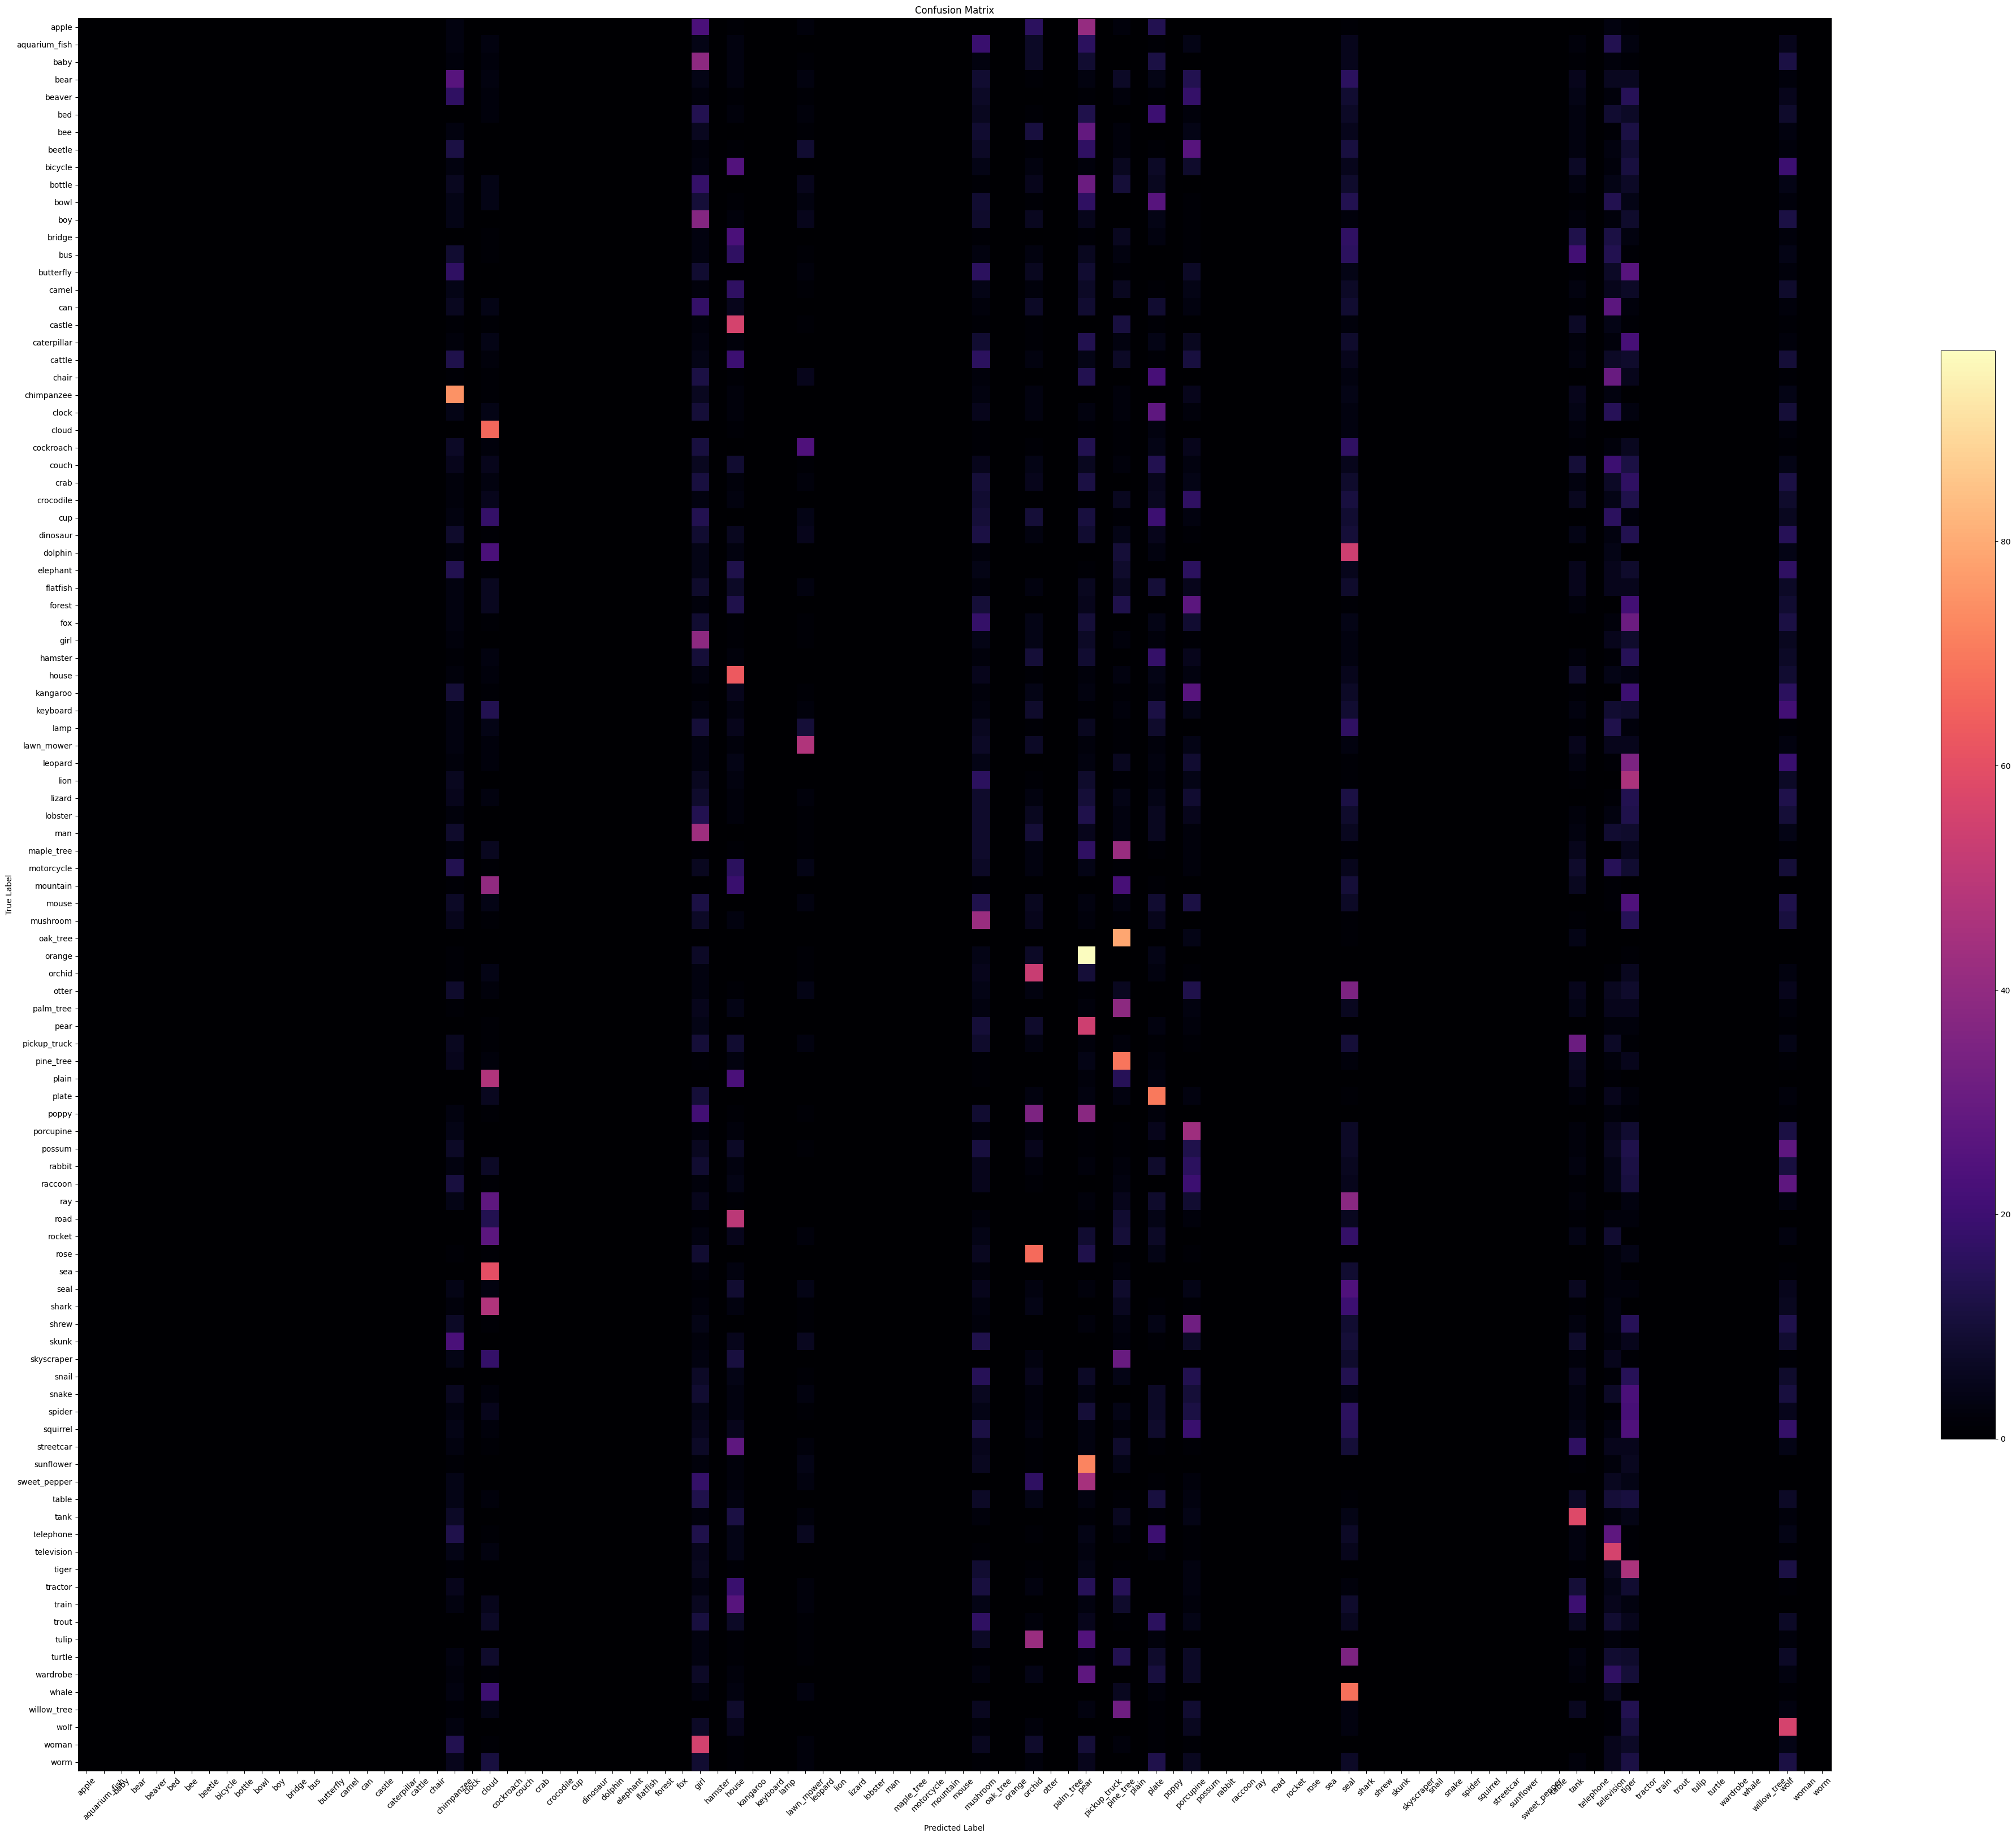

In [144]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(50, 50))
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.colormaps['magma'])

    ## https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps

    plt.colorbar(shrink=0.50)
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

last_result = history_resnet12[-1]
cm = last_result['confusion_matrix']
plot_confusion_matrix(cm, classes)

In [145]:
last_result = history_resnet12[-1]
precision = last_result['precision']
recall = last_result['recall']
f1 = last_result['f1']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.0155
Recall: 0.0888
F1 Score: 0.0258


In [146]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o', color = 'black')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

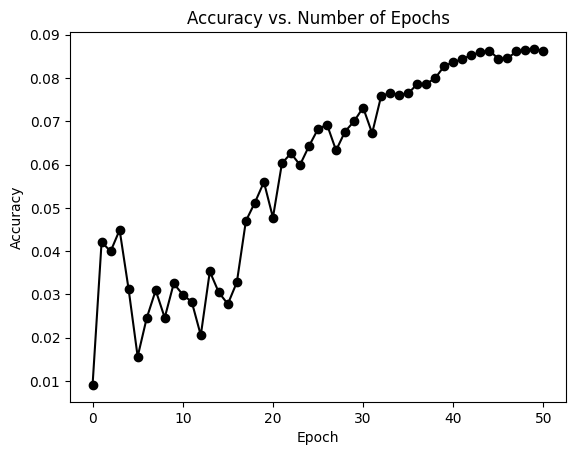

In [147]:
plot_accuracies(history_resnet12)

In [148]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, color = 'green')
    plt.plot(val_losses, color = 'brown')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

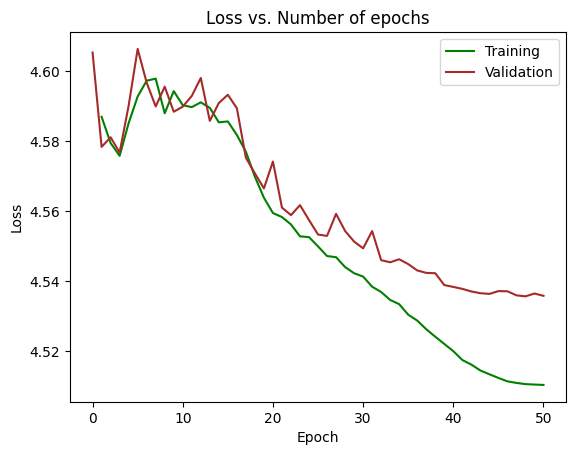

In [149]:
plot_losses(history_resnet12)

In [150]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, color = 'orange')
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');

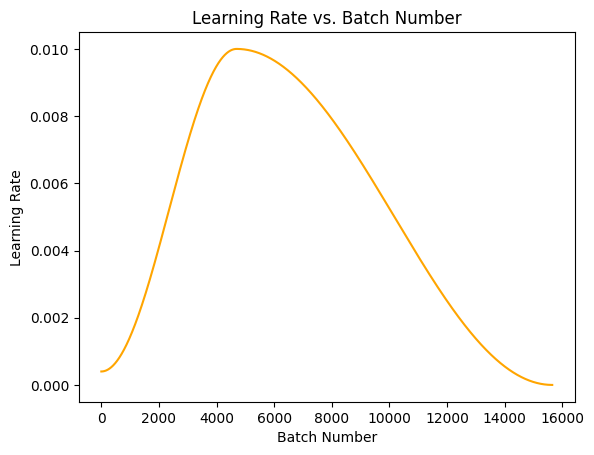

In [151]:
plot_lrs(history_resnet12)

In [152]:
test_resnet12 = evaluate(model_resnet12, test_loader) #final evaluation of resnet9 model with test dataset
test_resnet12

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 4.534550666809082, 'val_acc': 0.08811313658952713}

In [153]:
test_loss_resnet12 = test_resnet12['val_loss']
test_acc_resnet12 = test_resnet12['val_acc']
print('test_loss_resnet9:', test_resnet12['val_loss'])
print('test_acc_resnet9:', test_resnet12['val_acc'])

test_loss_resnet9: 4.534550666809082
test_acc_resnet9: 0.08811313658952713


In [154]:
torch.save(model_resnet12.state_dict(), 'ResNet12_v1_gumbel_softmax.pth')

In [158]:
def predict_image(img, model_resnet12):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_resnet12(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)

    print(yb)
    # Retrieve the class label
    # return yb

    return dataset.classes[preds[0].item()]

In [159]:
# import torch.nn.functional as F

# def predict_image(img, model_resnet9):
#     # Convert to a batch of 1
#     xb = to_device(img.unsqueeze(0), device)
#     # Get predictions from model
#     yb = model_resnet9(xb)
#     # Apply softmax to convert to probabilities
#     probs = F.log_softmax(yb, dim=1)
#     # Pick index with highest probability
#     _, preds = torch.max(probs, dim=1)
#     # Retrieve the class label
#     print(probs)
#     print(preds.shape)
#     # return probs
#     predicted_label = dataset.classes[preds[0].item()]
#     return predicted_label


tensor([[1.5109e-06, 6.6298e-06, 4.1119e-06, 5.5859e-07, 2.4853e-06, 1.9437e-06,
         6.5896e-06, 3.5862e-06, 3.5573e-06, 1.1601e-05, 5.4449e-06, 2.3560e-06,
         7.5377e-06, 2.9000e-06, 4.5049e-06, 3.1663e-06, 5.1597e-06, 1.7338e-06,
         3.1470e-06, 3.7732e-06, 5.4081e-06, 7.6853e-01, 9.4621e-07, 1.9315e-08,
         2.8006e-06, 1.7259e-06, 1.6150e-05, 4.3360e-06, 3.9439e-06, 1.9217e-06,
         1.7400e-06, 1.2590e-06, 4.2495e-06, 5.7959e-07, 2.7419e-06, 2.8470e-04,
         3.7606e-06, 3.7127e-04, 1.6273e-06, 5.4376e-06, 4.2837e-06, 1.3974e-05,
         2.5440e-06, 4.1220e-06, 5.2504e-06, 4.5948e-06, 6.2533e-06, 4.2179e-06,
         5.0308e-06, 3.0668e-06, 9.4881e-07, 2.7365e-02, 1.0540e-06, 2.8859e-06,
         1.2262e-06, 5.5724e-06, 5.1338e-06, 4.0528e-06, 7.3337e-07, 5.3096e-07,
         3.4169e-06, 1.2927e-07, 3.2453e-06, 8.4544e-02, 2.2625e-06, 8.2012e-06,
         3.0931e-06, 1.6636e-06, 4.2304e-06, 1.8622e-06, 9.2857e-06, 2.0147e-06,
         2.3376e-03, 3.6662e

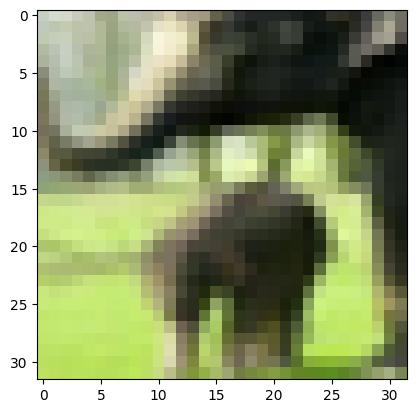

In [160]:
img, label = test_dataset[3480]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_resnet12))